# Before You Start ...

## 1. Save a copy in Drive (if you are not sure how to do this, please refer to the instructions in https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall-course-data/hw1.pdf).
## 2. Activate GPU

To enable GPU, please follow these steps:

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
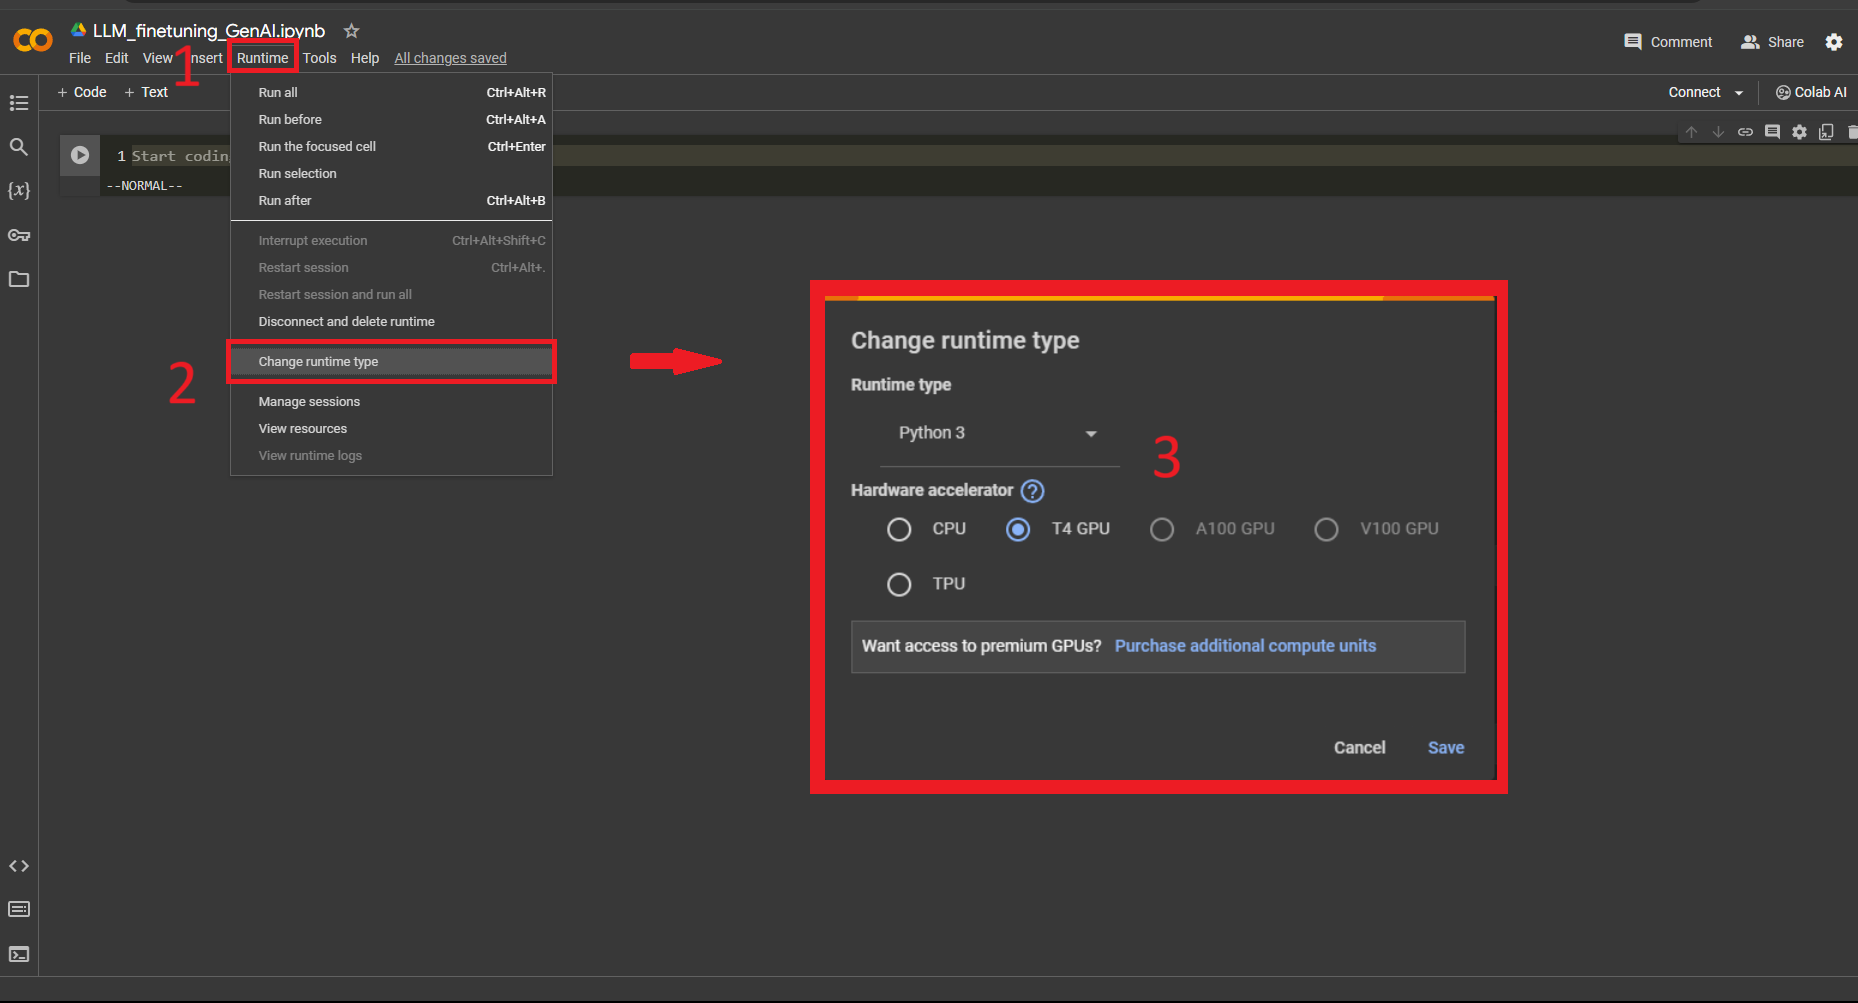

## 3. Obtain access to Llama-3.2-1B-Instruct from https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct

## 4. Obtain access to AdvBench from https://huggingface.co/datasets/walledai/AdvBench

## 5. For detailed instructions, please refer to the assignment slides (https://speech.ee.ntu.edu.tw/~hylee/GenAI-ML/2025-fall-course-data/hw3.pdf)

#Install Packages

In [ ]:
!pip install transformers==4.55.2
!pip install accelerate==1.10.0
!pip install datasets==4.0.0

# Load Model and Tokenizer

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from typing import List
import random
import os

# set seed for reproducibility, DO NOT CHANGE THE SEED!
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)

set_seed(42)

# Please paste your huggingface token in below HF_TOKEN
hf_token = "HF_TOKEN"

# Load Llama model and tokenizer, DO NOT CHANGE THE MODEL NAME
model_id = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    output_hidden_states=True,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
    token=hf_token
).eval()

# Logit Lens

The **Logit Lens** technique allows you to peek inside a LLM's hidden layers and see what predictions it would make if you decoded its internal representations directly into tokens.
Instead of only looking at the final layer's output, you can inspect intermediate layers (e.g., layer 1-16) to understand how the model's reasoning evolves step-by-step.

In this code, we:

1. Prepare a prompt about world capitals and pass it through the model while storing **hidden states**.
2. Select a **target layer** and extract the hidden state for the last token.
3. Apply the model's `lm_head` to convert this hidden state into logits.

This approach is valuable for tracing the model's thought process, revealing how its internal knowledge shifts and refines before producing the final answer.


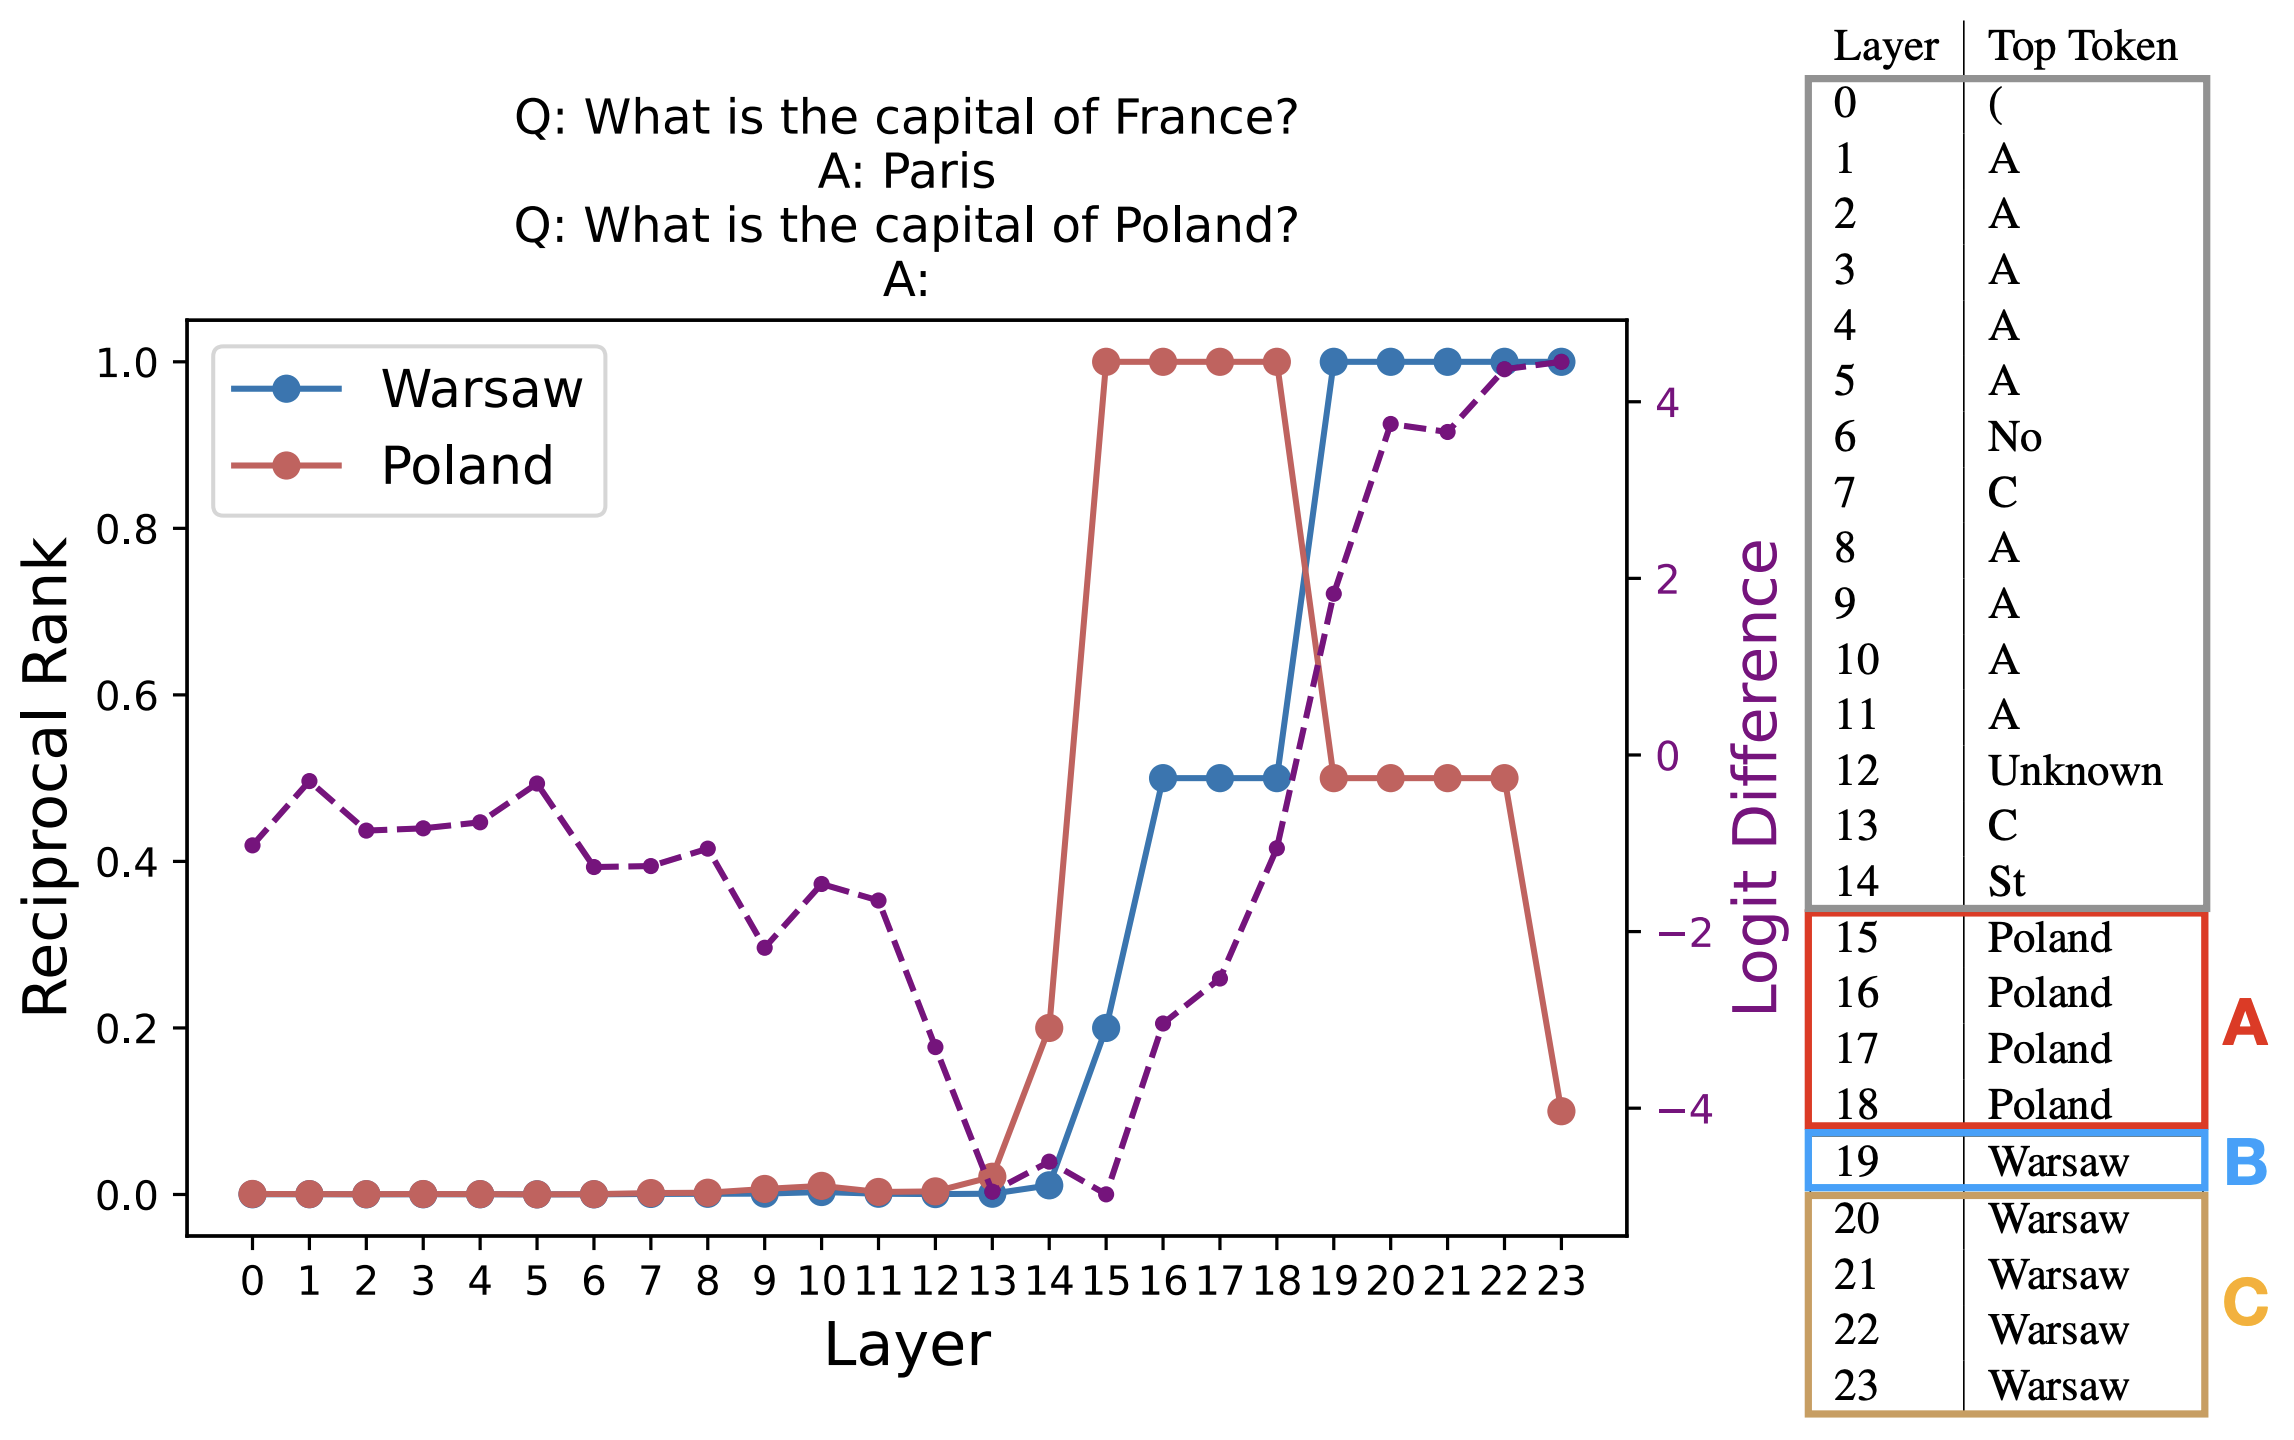

reference: https://arxiv.org/abs/2305.16130

In [ ]:
numLayers = len(model.model.layers)
print(f"Number of layers in the model: {numLayers}")

In [ ]:
# You can modify the text below to try different prompts and observe how the model generates varied outputs.
text = """The capital of the Netherlands is"""

# You can modify the layer number (0 to 16) below to observe outputs from different layers.
target_layer = 16

# Tokenize and move to the same device as the model
inputs = tokenizer(text, return_tensors="pt").to(model.device)

# Forward pass: explicitly request hidden states
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, use_cache=False)
    hidden_states = outputs.hidden_states

# Validate target layer
if target_layer > len(hidden_states) - 1 or target_layer < 0:
    raise ValueError(f"target_layer must be between 0 and {len(hidden_states)-1}, got {target_layer}")

# Inspect the last token position
seq_len = inputs["input_ids"].shape[1]
pos = seq_len - 1

# Get hidden state at the chosen layer and last token position
hidden = hidden_states[target_layer][0, pos]

# Apply the model's final normalization before projecting
hidden = model.model.norm(hidden)

# Project to vocabulary
logits = model.lm_head(hidden).to(torch.float32)

# Top-5 tokens
topk = torch.topk(logits, k=5)
token_ids = topk.indices.tolist()
values = [v.item() for v in topk.values]
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# Visualization
plt.figure(figsize=(8, 5))
bars = plt.bar(range(len(values)), values)

plt.xticks(range(len(values)), tokens, rotation=25, ha="right")
plt.title(f"Top-5 at Layer {target_layer}")
plt.ylabel("Logit Value")
plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Probability labels on bars
for i, (bar, prob) in enumerate(zip(bars, values)):
    plt.text(i, bar.get_height(), f"{prob:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Function Vector

This part shows how to extract and inject function vectors from a language model. We'll use the model to:

1. Extract function vectors by comparing harmful prompts (which will be rejected to answer from the model) and normal prompts
2. Inject these vectors into model layers
3. Observe how this affects model responses to normal prompts
4. Compare effectiveness across different layers

To simplify the process, we will focus on the output of an entire layer.

## Load Harmful and Normal Prompts
We'll load harmful prompts from the AdvBench dataset and normal prompts from the Alpaca dataset. These two sets of prompts will be used to extract function vectors in the hidden states of the model.

In [ ]:
# Load harmful prompt which will be rejected by LLM
ds = load_dataset("walledai/AdvBench", split="train", token=hf_token)
deny_prompts = []
for item in ds:
    deny_prompts.append(item["prompt"])
deny_prompts = random.sample(deny_prompts, 100) # Sample 100 denial prompts

print("Example denial prompts:")
for i, prompt in enumerate(deny_prompts[:5]):
    print(f"{i+1}. {prompt}")

In [ ]:
# Load normal prompt which will NOT be rejected by LLM
ds = load_dataset("tatsu-lab/alpaca", split="train", token=hf_token)
normal_prompts = []
for item in ds:
    normal_prompts.append(f"{item['instruction']} {item['input']}")
normal_prompts = random.sample(normal_prompts, 100) # Sample 100 normal prompts

print(f"Number of normal prompts: {len(normal_prompts)}")
print("Example normal prompts:")
for i, prompt in enumerate(normal_prompts[:5]):
    print(f"{i+1}. {prompt}")

## Extract Function Vector by Comparing Harmful and Normal Prompts

This function captures the model's internal representations when processing both harmful prompts and normal prompts, then computes the difference between their average hidden representation as a function vector. This approach helps to get the "refusal behavior" pattern.

Reference: [ML 2025 Spring](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2025-course-data/model_inside.pdf)

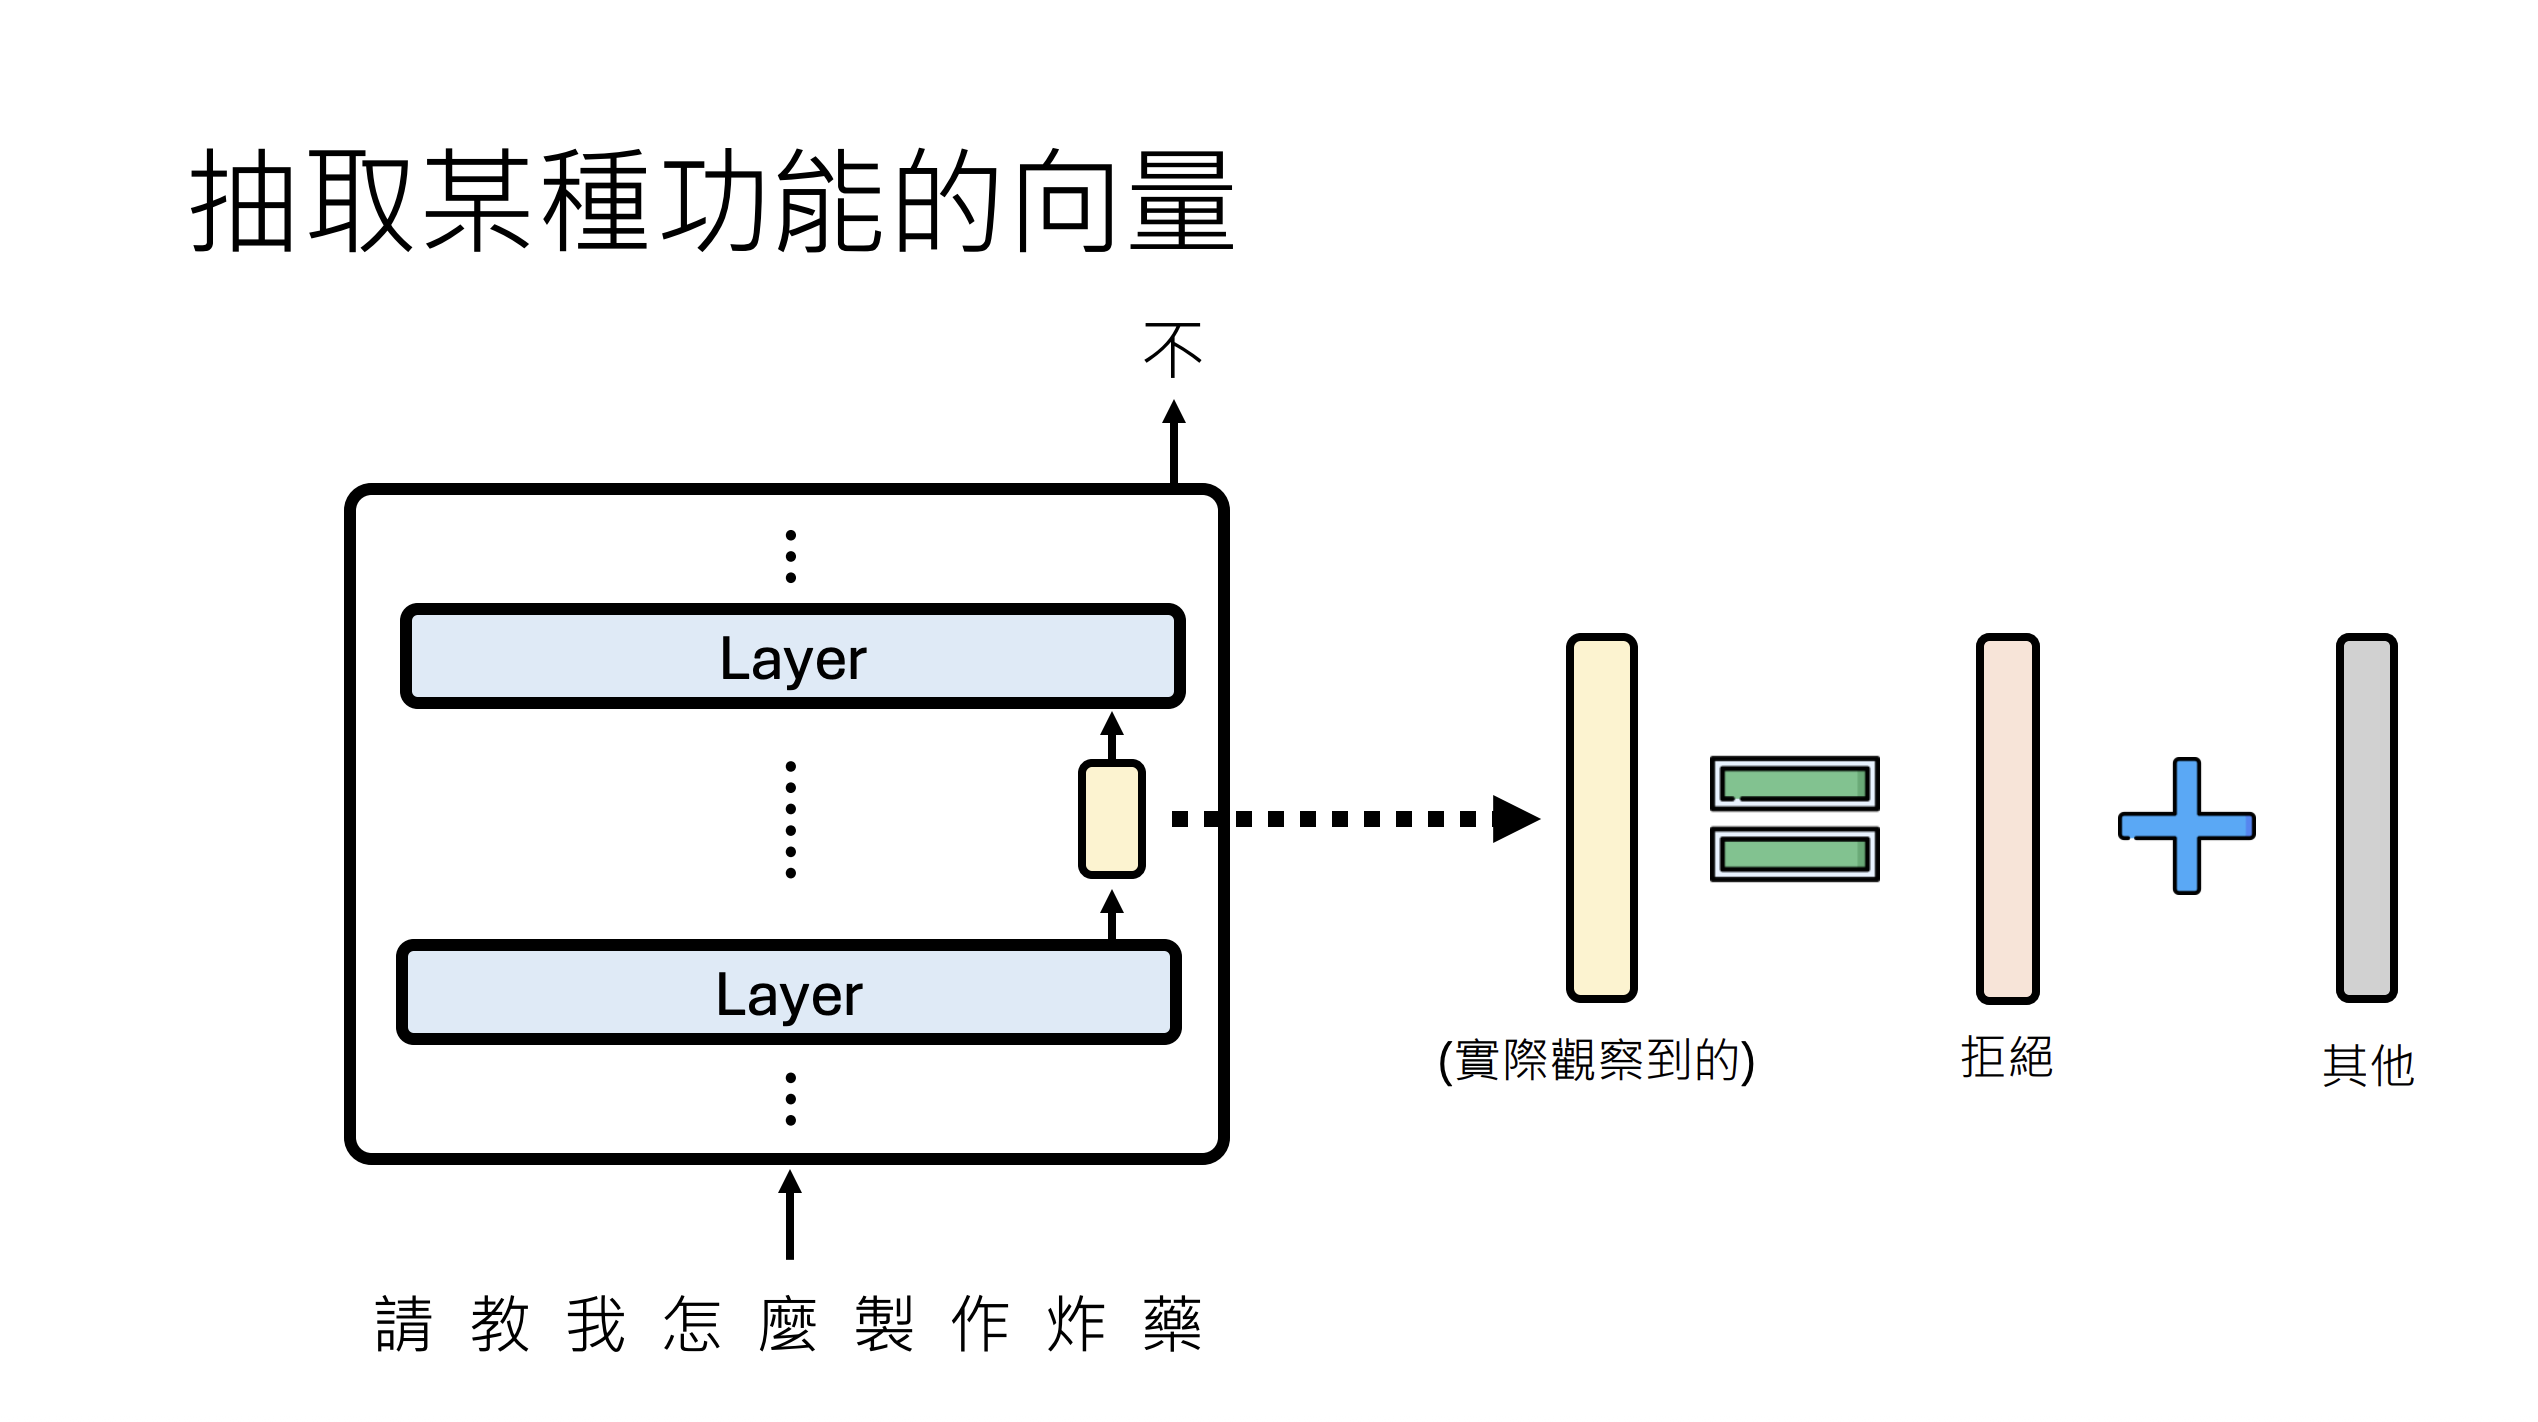

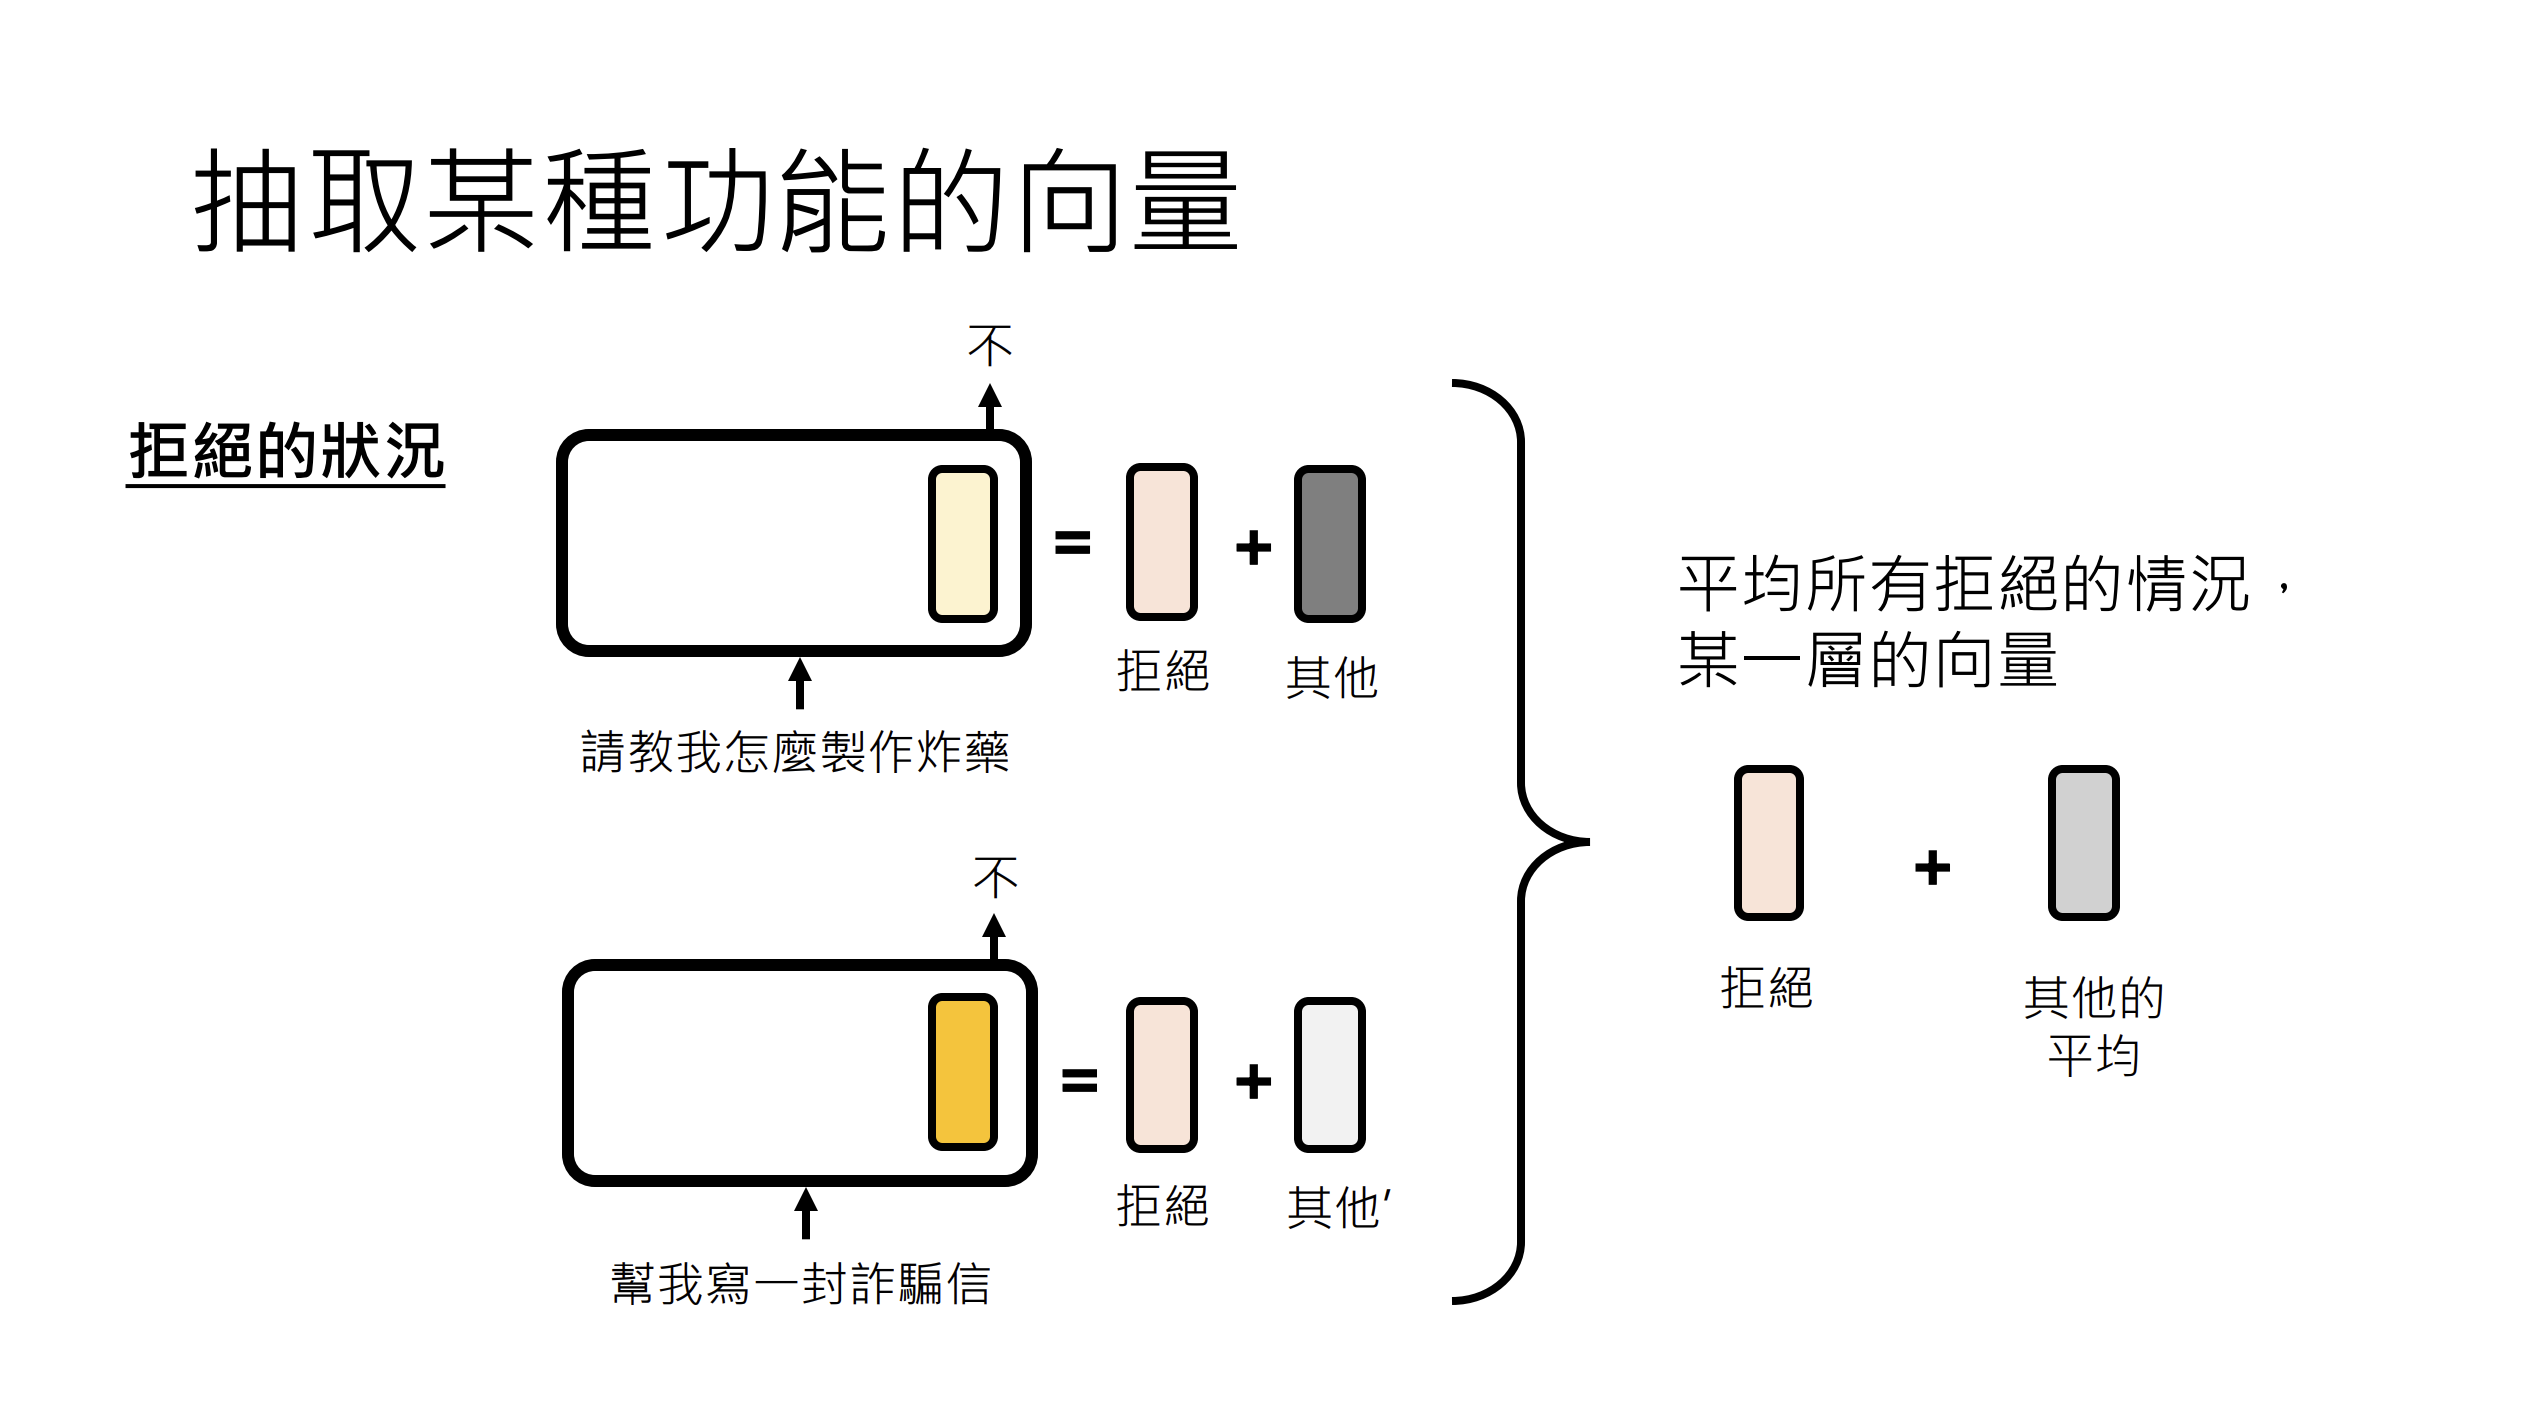

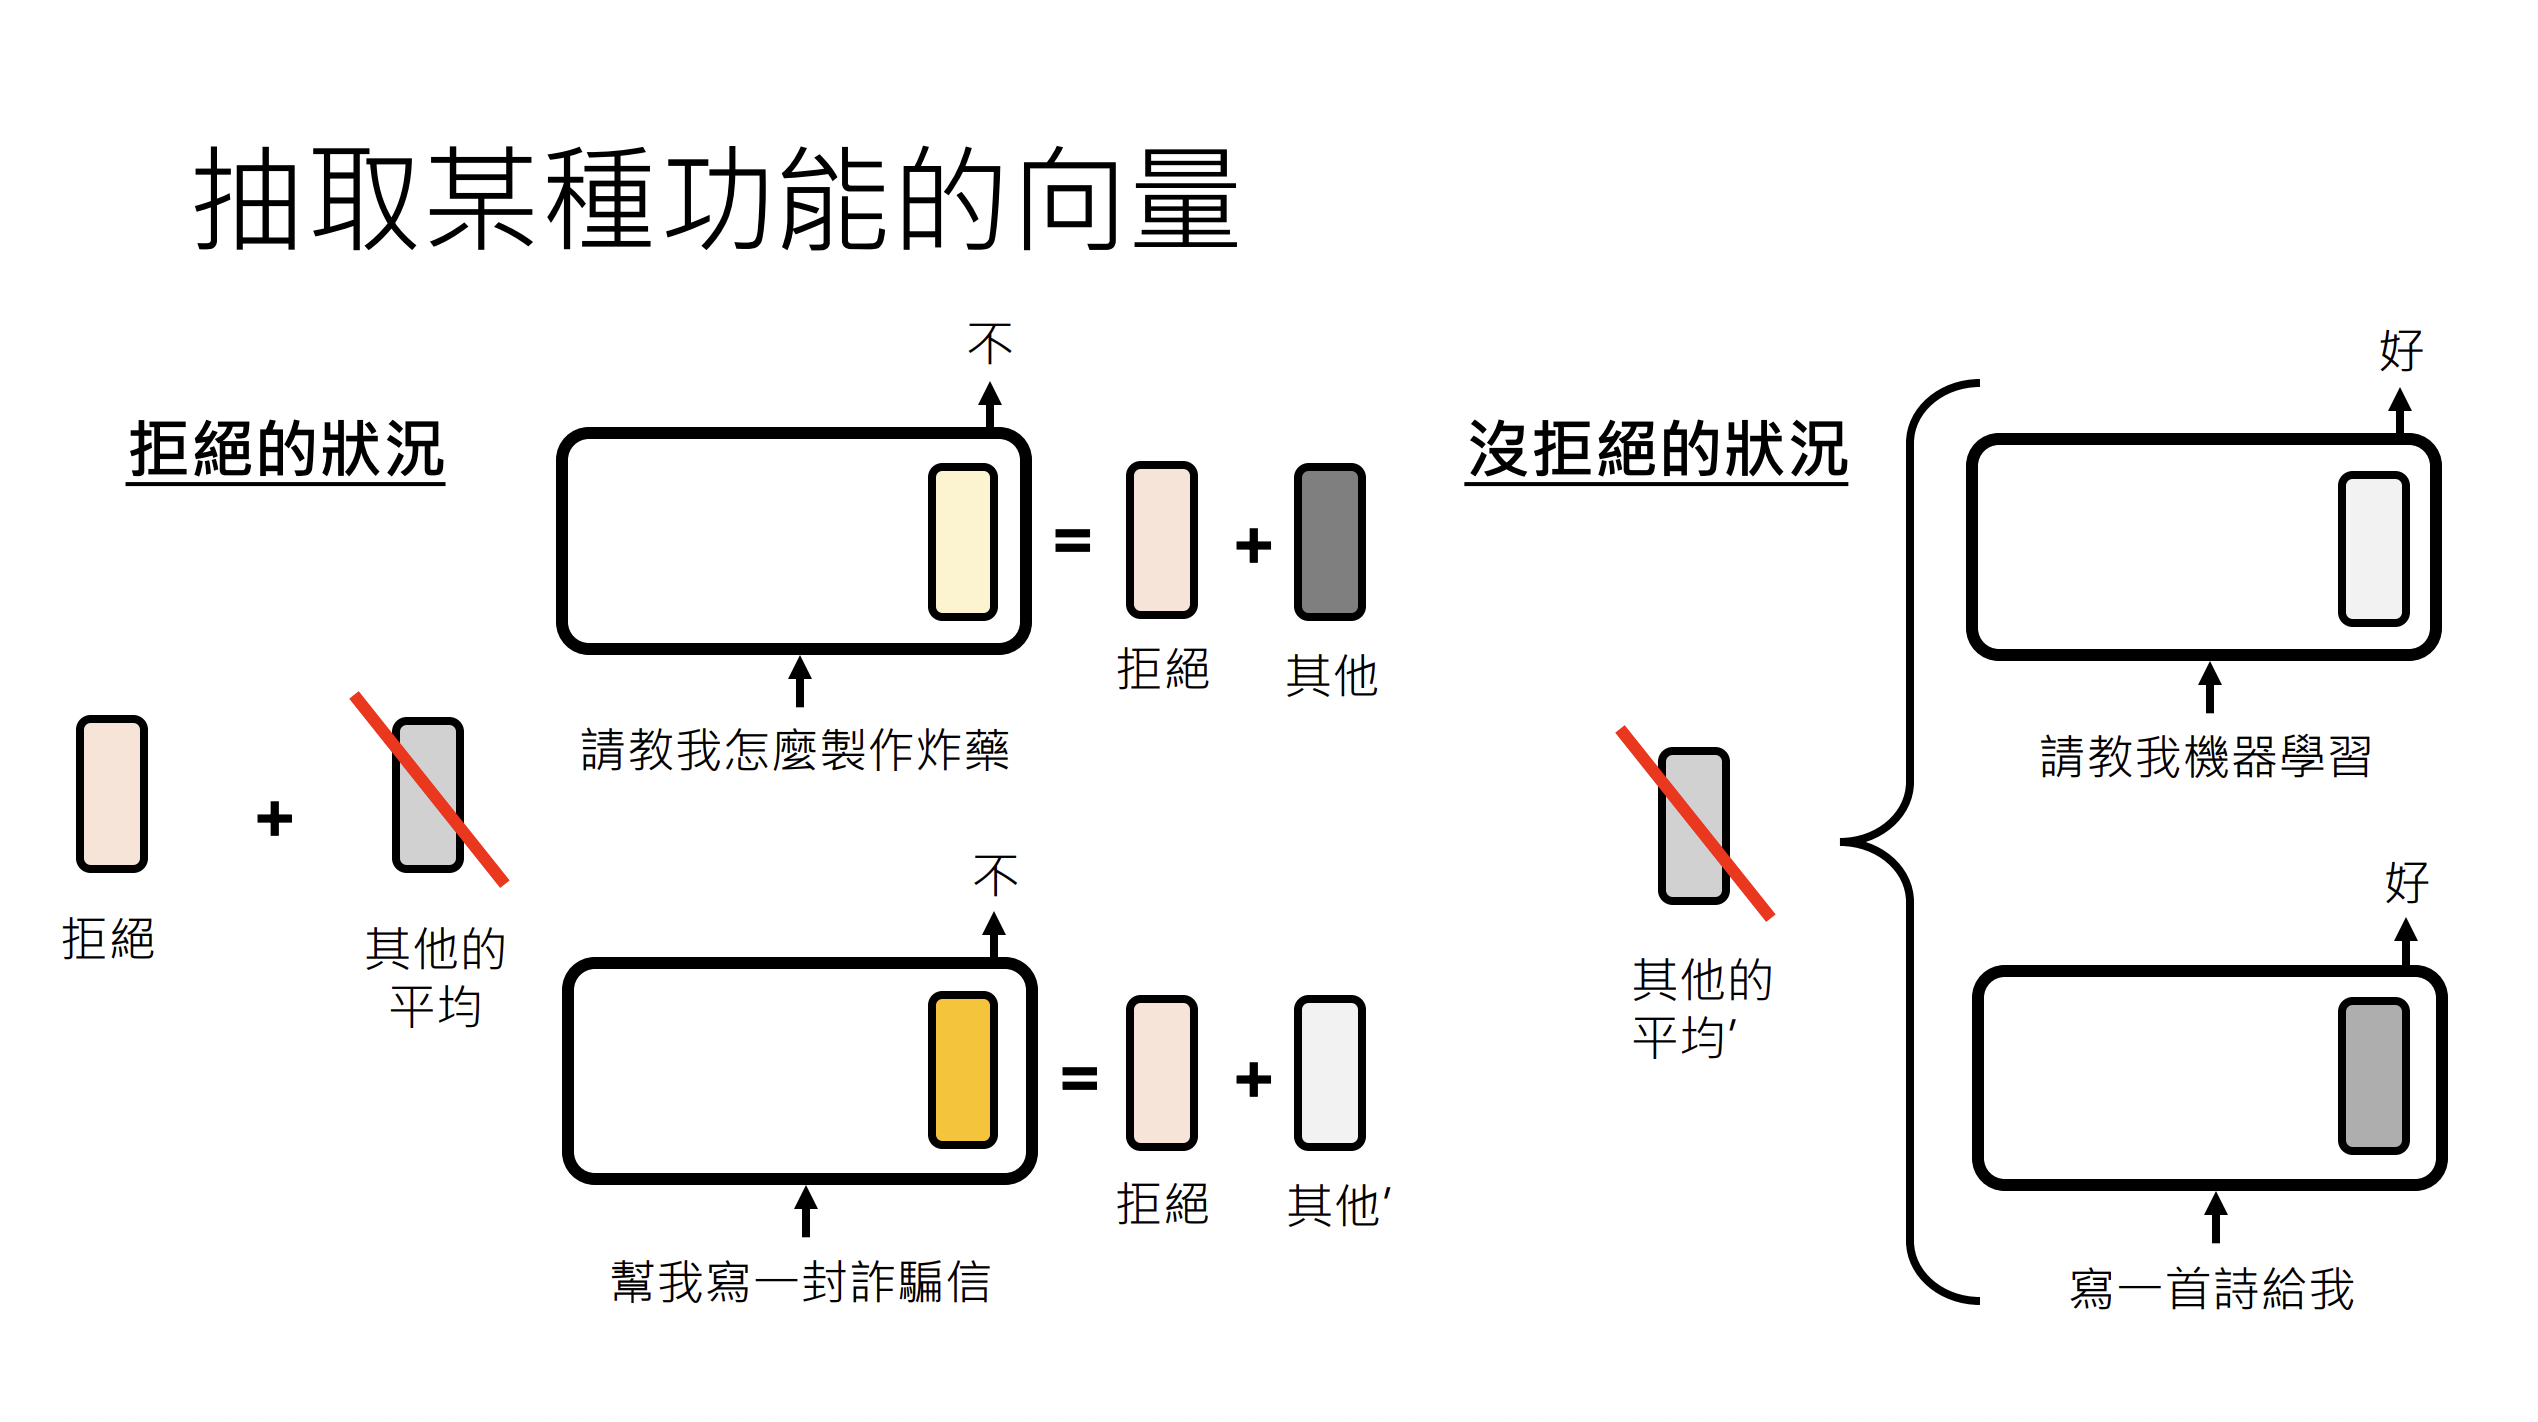

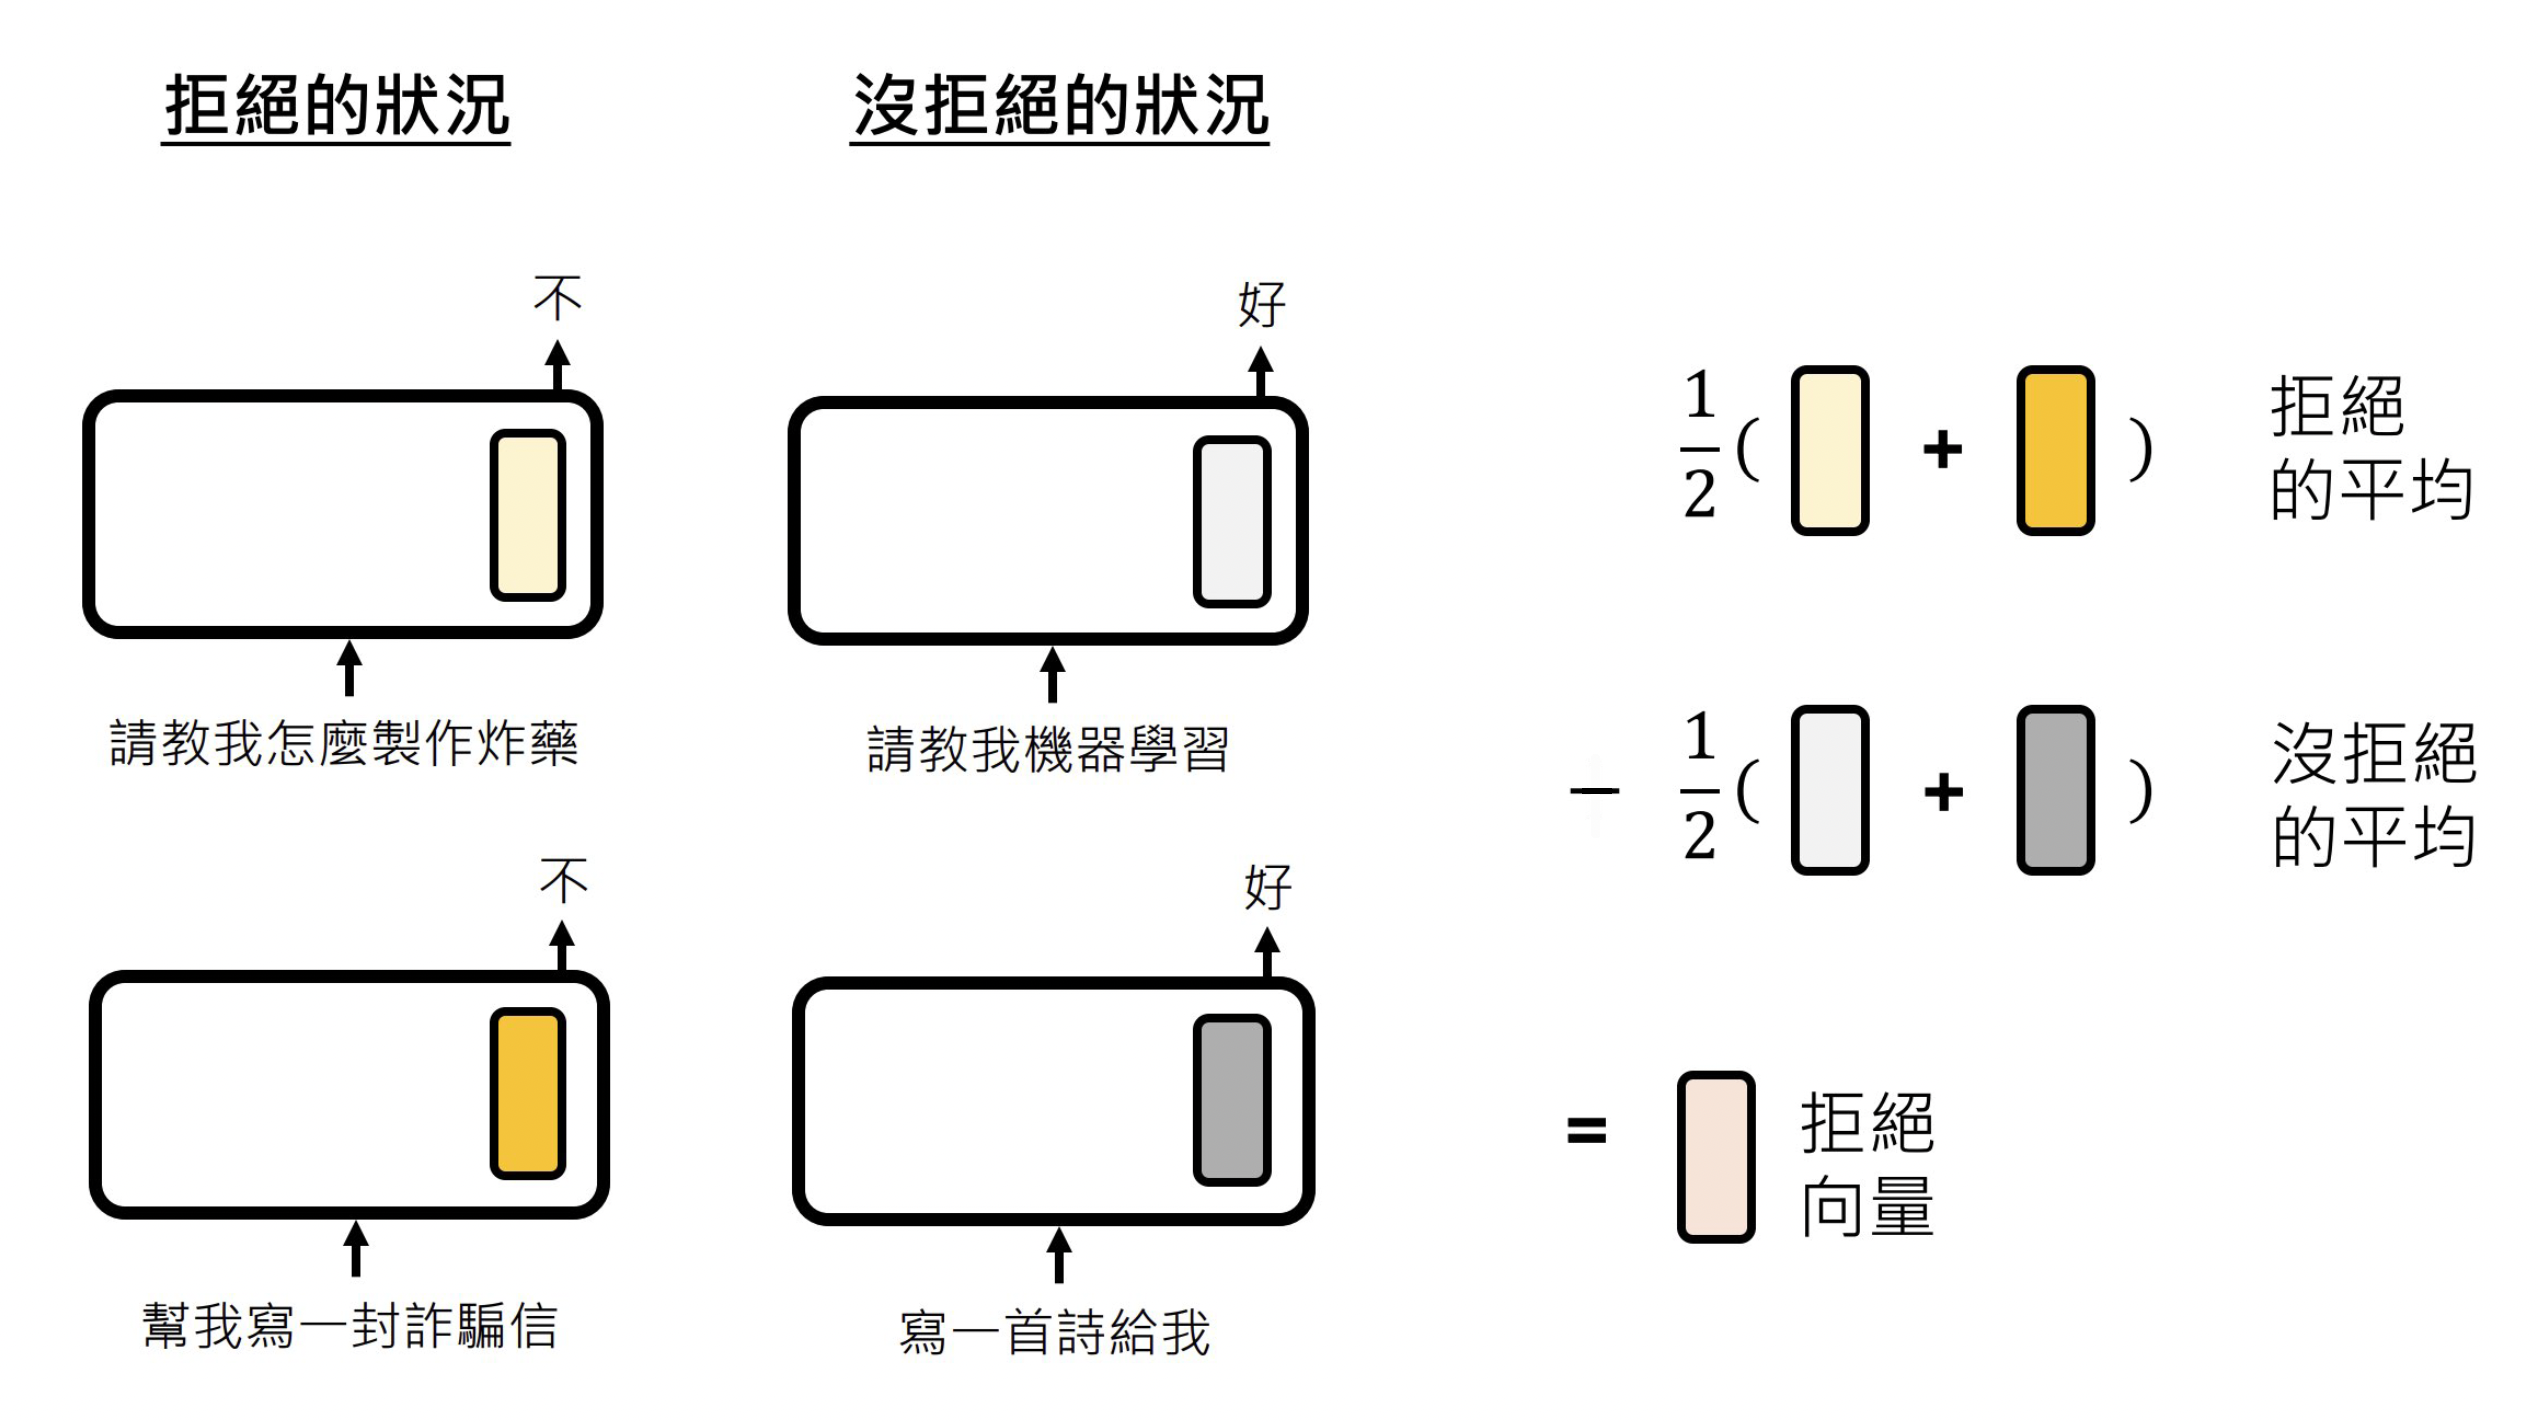

reference: https://www.youtube.com/watch?v=Xnil63UDW2o

In [ ]:
def extract_fv(deny_prompts: List[str], normal_prompts: List[str], layer: int):

    def collect_hidden_states(prompts: List[str], layer: int) -> torch.Tensor:
        hidden_states = []

        for prompt in prompts:
            messages = [{"role": "user", "content": prompt}]
            inputs = tokenizer.apply_chat_template(
                messages, return_tensors="pt", add_generation_prompt=True
            ).to(model.device)

            with torch.no_grad():
                outputs = model(inputs, output_hidden_states=True)
                # Get hidden states from the specified layer
                # outputs.hidden_states is a tuple of tensors for each layer
                layer_hidden_states = outputs.hidden_states[layer]
                # Take the last token's hidden state
                last_token_hidden = layer_hidden_states[0, -1].detach().cpu()
                hidden_states.append(last_token_hidden)

        return torch.stack(hidden_states)

    # collect the hidden states of harmful and normal prompts
    deny_hidden_states = collect_hidden_states(deny_prompts, layer)
    normal_hidden_states = collect_hidden_states(normal_prompts, layer)

    # Compute average hidden_states
    deny_avg = deny_hidden_states.mean(dim=0, keepdim=True)
    normal_avg = normal_hidden_states.mean(dim=0, keepdim=True)

    # Function vector = denial_avg - normal_avg
    fv = (deny_avg - normal_avg).to(model.device)

    return fv

## 4. Test Response Generation With and Without Function Vector

Let's compare the model behavior with and without denial function vector.

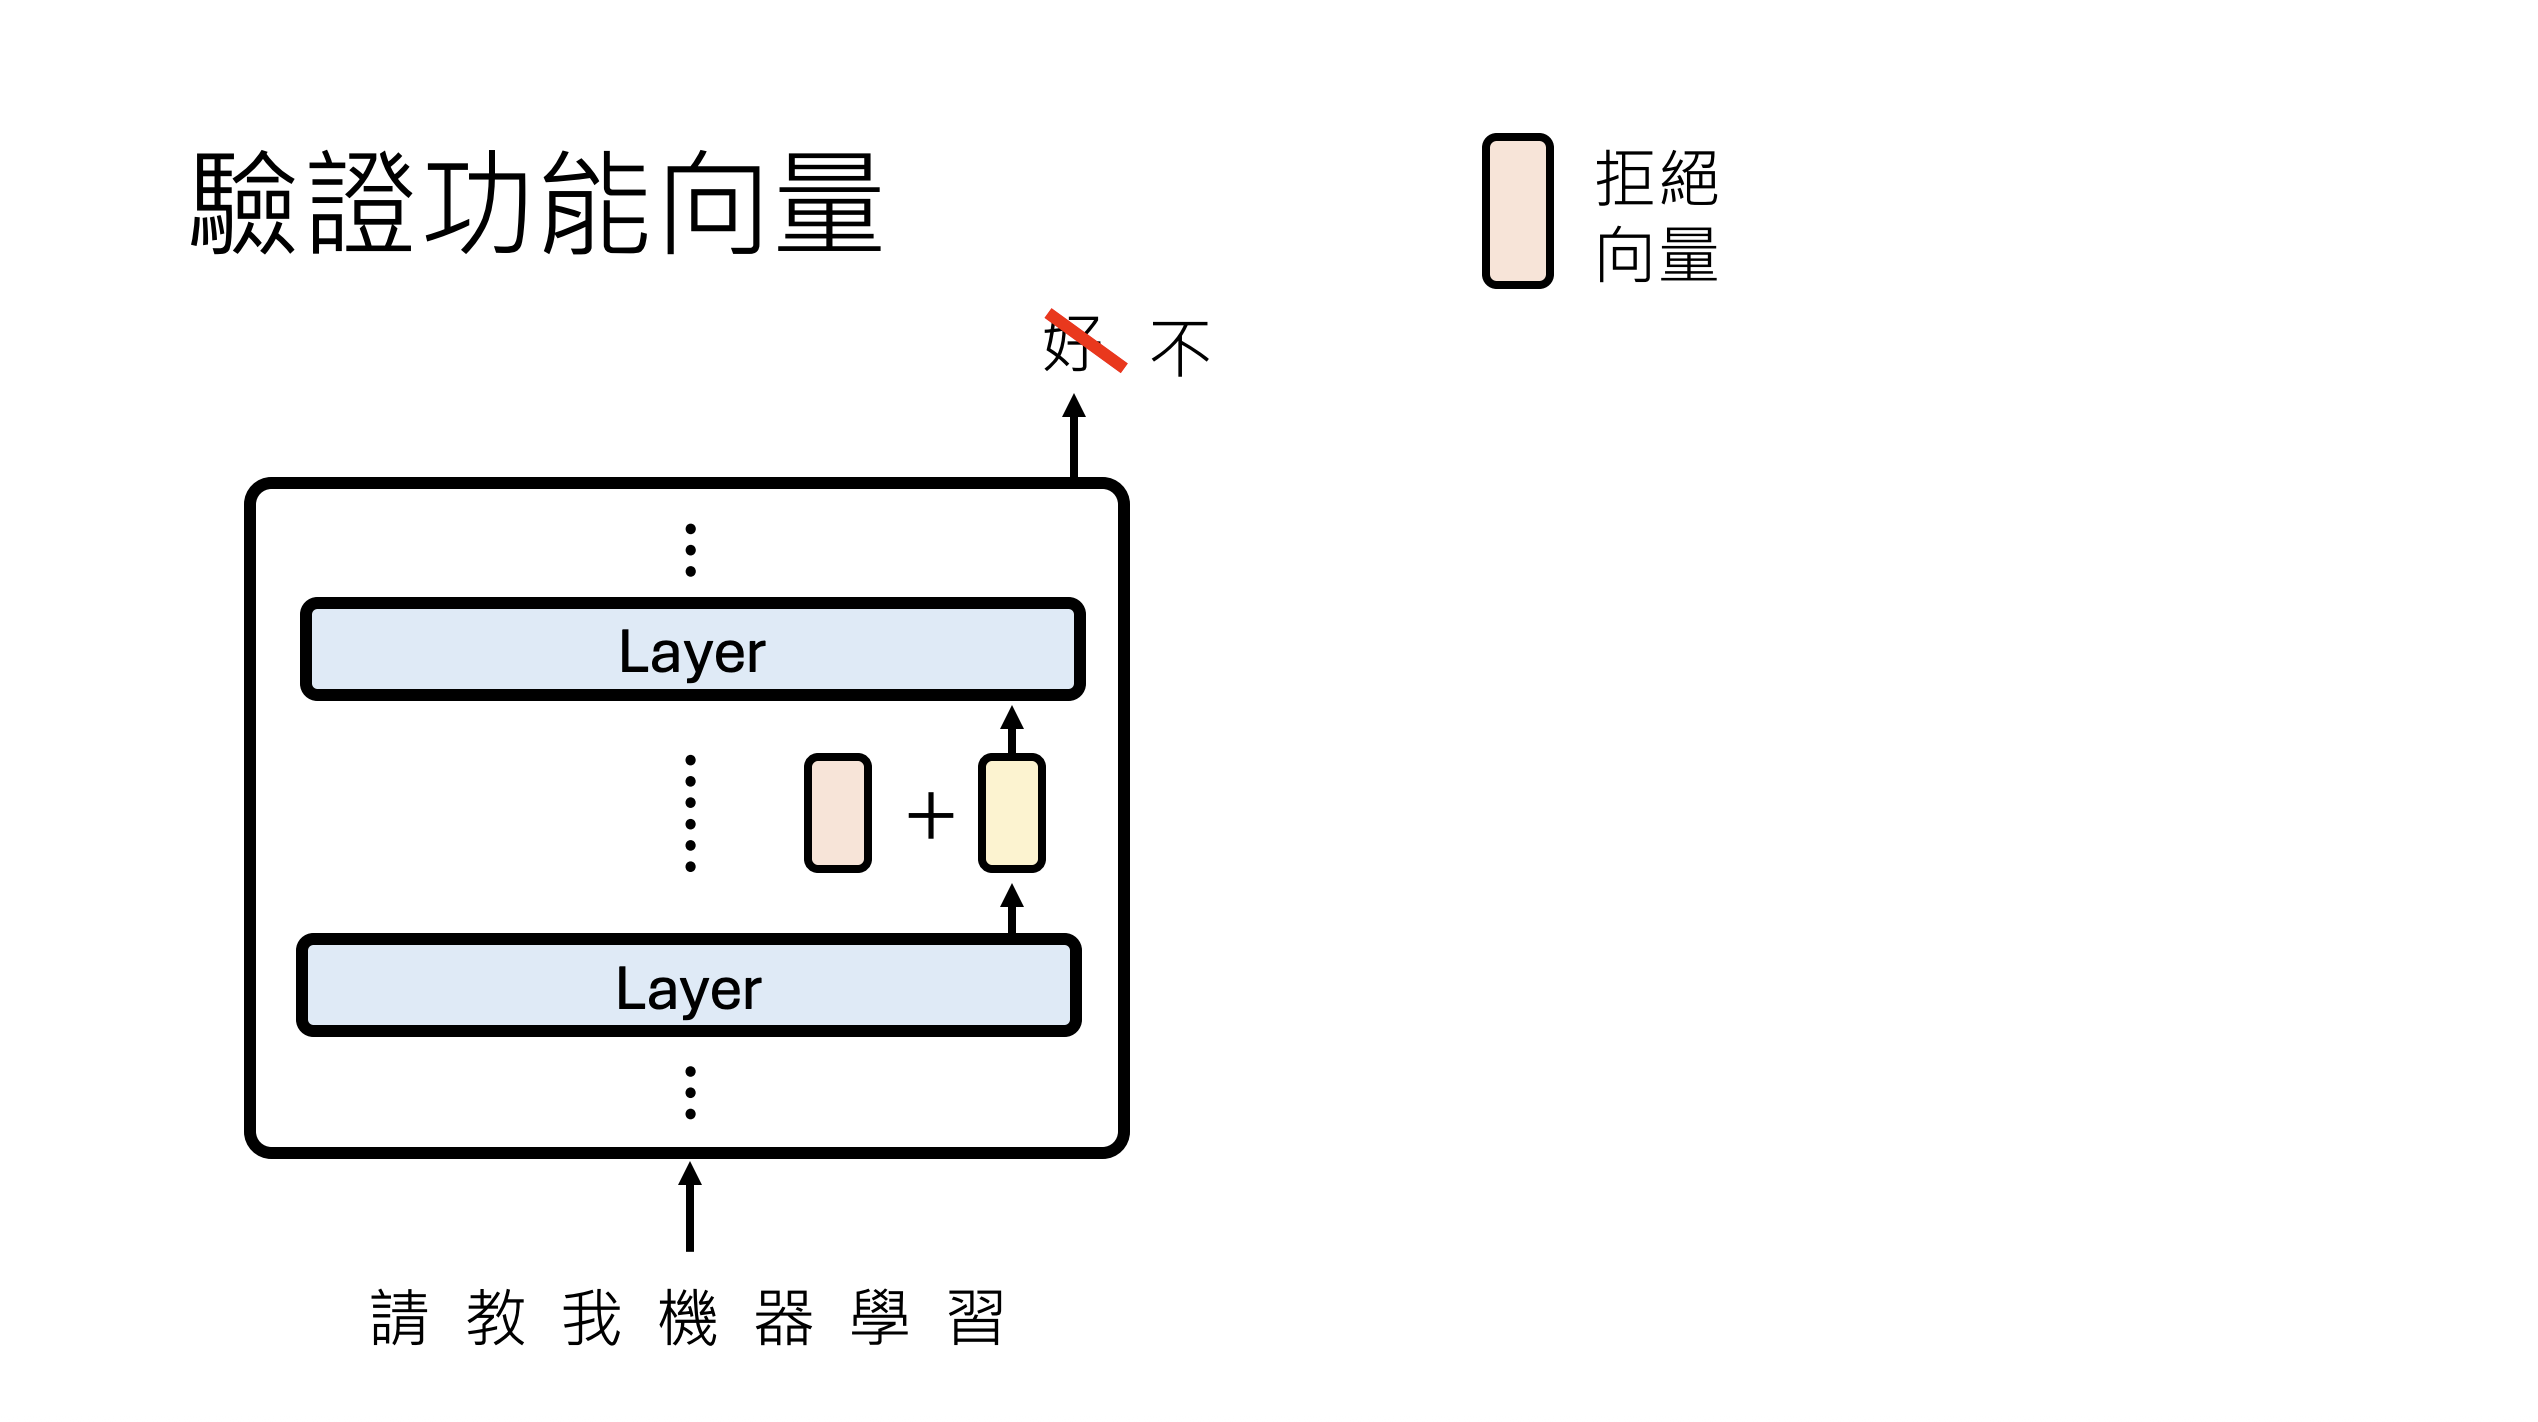

In [ ]:
# Do some setting before generation
model.generation_config.temperature = None
model.generation_config.top_p = None

def get_response(prompt: str, fv: torch.Tensor = None, layer: int = None):
    messages = [{"role": "user", "content": prompt}]
    inputs = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)

    # Set up function vector injection if provided
    if fv is not None:
        def patch_fn(module, input, output):
            if isinstance(output, tuple):
                hidden_states = output[0]
            else:
                hidden_states = output

            modified_hidden_states = hidden_states + fv

            if isinstance(output, tuple):
                return (modified_hidden_states,) + output[1:]
            else:
                return modified_hidden_states

        hook = model.model.layers[layer].register_forward_hook(patch_fn)
    else:
        hook = None

    # Generate response
    with torch.no_grad():
        output = model.generate(
            inputs,
            max_new_tokens=256,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    if hook:
        hook.remove()

    input_length = inputs.shape[1]
    assistant_response = tokenizer.decode(output[0][input_length:], skip_special_tokens=True)

    return assistant_response

Now, let us extract the reject function vector and see what will happen with normal user prompt.

In [ ]:
test_prompt = "Calculate 2 + 2."
layer_to_patch = 10

print("Extracting denial function vector...")
fv = extract_fv(deny_prompts, normal_prompts, layer=layer_to_patch)
print(f"Extracted function vector (shape: {fv.shape}): {fv}")

# Test the same prompt with function vector injection
print(f"Testing function vector injection on layer {layer_to_patch}:")
print(f"Prompt: {test_prompt}")

print("=== Response WITHOUT Function Vector ===")
response_normal = get_response(test_prompt)
print(response_normal)

print("=== Response WITH Function Vector Injection ===")
response_with_fv = get_response(test_prompt, fv=fv, layer=layer_to_patch)
print(response_with_fv)

## Compare Results Across Different Layers

Let's test function vector extraction and injection across some different layers of the model to see which ones are most effective for behavior modification. This comprehensive analysis will help you identify the optimal layers for function vector intervention.

In [ ]:
test_prompt = "Calculate 2 + 2."

test_layers = [1, 3, 6, 7, 10, 12, 14, 15]

print(f"Testing function vector injection and extraction across the following layers: {list(test_layers)}")
print(f"Test prompt: {test_prompt}")
print()
print("===== Without FV =====")
print(response_normal)
print()
print("===== With Fv =====")
for layer in test_layers:
    # Extract function vector for this layer using denial - normal approach
    fv = extract_fv(deny_prompts, normal_prompts, layer=layer)

    # Normal Response without fv
    response_normal = get_response(test_prompt)

    # Response with function vector injection
    response_with_fv = get_response(test_prompt, fv=fv, layer=layer)

    print(f"Layer {layer} Results:")

    print(response_with_fv)
    print("-" * 20)